In [1]:
"""
APRENDIZAJE EN CONJUNTO (ENSEMBLE LEARNING)
==========================================

Objetivos:
- Comprender conceptos y métodos básicos del aprendizaje en conjunto
- Implementar Blending, Bagging y Stacking desde cero
- Mejorar precisión del modelo combinando múltiples algoritmos
- Aplicar técnicas en dataset real de precios de viviendas

Sprint: Métodos avanzados de ensemble learning
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("="*80)
print("APRENDIZAJE EN CONJUNTO (ENSEMBLE LEARNING)")
print("Implementación de Blending, Bagging y Stacking desde cero")
print("="*80)


APRENDIZAJE EN CONJUNTO (ENSEMBLE LEARNING)
Implementación de Blending, Bagging y Stacking desde cero


In [2]:
# ============================================================================
# 1. FUNDAMENTOS TEÓRICOS DEL APRENDIZAJE EN CONJUNTO
# ============================================================================

print("📚 1. FUNDAMENTOS TEÓRICOS")
print("="*30)

print("""
🎯 APRENDIZAJE EN CONJUNTO:
──────────────────────────

📊 CONCEPTO CENTRAL:
   • Combina múltiples modelos para predicciones más robustas
   • Aprovecha fortalezas individuales, minimiza debilidades
   • Reduce varianza, sesgo y overfitting
   • Mejora generalización en datos no vistos

🔬 PRINCIPIO FUNDAMENTAL:
   • "Sabiduría de las multitudes"
   • Modelos individuales cometen errores diferentes
   • Promedio de predicciones reduce error total
   • Diversidad es clave para éxito del ensemble

📈 TIPOS DE ENSEMBLE:
   
   1️⃣ BLENDING (Mezcla):
      • Combina predicciones con pesos fijos
      • Modelos entrenados independientemente
      • Promedio ponderado de predicciones
      • Simple pero efectivo
   
   2️⃣ BAGGING (Bootstrap Aggregating):
      • Múltiples modelos en subconjuntos de datos
      • Muestreo con reemplazo (bootstrap)
      • Reduce varianza, mejora estabilidad
      • Ejemplos: Random Forest
   
   3️⃣ STACKING (Apilamiento):
      • Modelos de primer nivel → Meta-modelo
      • Aprende cómo combinar predicciones
      • Más complejo pero más flexible
      • Dos niveles: base learners + meta-learner

🧮 MATEMÁTICA DEL ENSEMBLE:
   • Blending: ŷ = Σᵢ wᵢ × hᵢ(x)
   • Bagging: ŷ = (1/M) × Σⱼ hⱼ(x)
   • Stacking: ŷ = g(h₁(x), h₂(x), ..., hₘ(x))

💡 VENTAJAS:
   • Mayor precisión que modelos individuales
   • Mejor generalización
   • Robustez ante outliers
   • Reduce overfitting

⚠️ CONSIDERACIONES:
   • Mayor complejidad computacional
   • Menos interpretabilidad
   • Riesgo de overfitting si no hay diversidad
   • Requiere validación cuidadosa
""")

print("✅ Fundamentos teóricos establecidos")


📚 1. FUNDAMENTOS TEÓRICOS

🎯 APRENDIZAJE EN CONJUNTO:
──────────────────────────

📊 CONCEPTO CENTRAL:
   • Combina múltiples modelos para predicciones más robustas
   • Aprovecha fortalezas individuales, minimiza debilidades
   • Reduce varianza, sesgo y overfitting
   • Mejora generalización en datos no vistos

🔬 PRINCIPIO FUNDAMENTAL:
   • "Sabiduría de las multitudes"
   • Modelos individuales cometen errores diferentes
   • Promedio de predicciones reduce error total
   • Diversidad es clave para éxito del ensemble

📈 TIPOS DE ENSEMBLE:
   
   1️⃣ BLENDING (Mezcla):
      • Combina predicciones con pesos fijos
      • Modelos entrenados independientemente
      • Promedio ponderado de predicciones
      • Simple pero efectivo
   
   2️⃣ BAGGING (Bootstrap Aggregating):
      • Múltiples modelos en subconjuntos de datos
      • Muestreo con reemplazo (bootstrap)
      • Reduce varianza, mejora estabilidad
      • Ejemplos: Random Forest
   
   3️⃣ STACKING (Apilamiento):
      • Mod

In [3]:
# ============================================================================
# 2. CARGA Y PREPARACIÓN DE DATOS
# ============================================================================

print("\n📊 2. CARGA Y PREPARACIÓN DE DATOS")
print("="*40)

# Cargar datos de precios de viviendas
print("🏠 CARGANDO DATASET DE PRECIOS DE VIVIENDAS:")
try:
    # Intentar cargar el archivo
    house_data = pd.read_csv('train (1).csv')
    print(f"   ✅ Archivo cargado exitosamente")
except FileNotFoundError:
    print(f"   ⚠️ Archivo 'train (1).csv' no encontrado")
    print(f"   📊 Generando datos sintéticos similares...")
    
    # Generar datos sintéticos si no se encuentra el archivo
    np.random.seed(42)
    n_samples = 1460
    
    # Generar características correlacionadas con precio
    year_built = np.random.randint(1872, 2010, n_samples)
    gr_liv_area = np.random.normal(1500, 500, n_samples)
    gr_liv_area = np.clip(gr_liv_area, 334, 5642)  # Rango realista
    
    # Precio basado en área y año con algo de ruido
    base_price = (gr_liv_area * 80 + (year_built - 1900) * 300 + 
                  np.random.normal(0, 20000, n_samples))
    sale_price = np.clip(base_price, 34900, 755000)  # Rango realista
    
    house_data = pd.DataFrame({
        'YearBuilt': year_built,
        'GrLivArea': gr_liv_area,
        'SalePrice': sale_price
    })
    
    print(f"   ✅ Datos sintéticos generados")

print(f"   • Forma del dataset: {house_data.shape}")
print(f"   • Columnas disponibles: {list(house_data.columns)}")

# Seleccionar variables según especificación
print(f"\n🎯 SELECCIONANDO VARIABLES:")
print(f"   • Variable dependiente: SalePrice")
print(f"   • Variables explicativas: GrLivArea, YearBuilt")

# Verificar que las columnas necesarias existen
required_columns = ['SalePrice', 'GrLivArea', 'YearBuilt']
missing_columns = [col for col in required_columns if col not in house_data.columns]

if missing_columns:
    print(f"   ⚠️ Columnas faltantes: {missing_columns}")
    # Crear columnas faltantes si es necesario
    if 'SalePrice' in missing_columns:
        house_data['SalePrice'] = house_data.iloc[:, -1]  # Usar última columna
    if 'GrLivArea' in missing_columns:
        house_data['GrLivArea'] = house_data.iloc[:, 0] if len(house_data.columns) > 0 else 1500
    if 'YearBuilt' in missing_columns:
        house_data['YearBuilt'] = house_data.iloc[:, 1] if len(house_data.columns) > 1 else 1990

# Extraer variables
X = house_data[['GrLivArea', 'YearBuilt']].copy()
y = house_data['SalePrice'].copy()

print(f"   • X shape: {X.shape}")
print(f"   • y shape: {y.shape}")

# Estadísticas descriptivas
print(f"\n📈 ESTADÍSTICAS DESCRIPTIVAS:")
print(f"Variables explicativas:")
print(X.describe())
print(f"\nVariable dependiente:")
print(y.describe())

# Verificar valores faltantes
print(f"\n🔍 VALORES FALTANTES:")
missing_info = pd.DataFrame({
    'Missing Count': X.isnull().sum(),
    'Missing %': (X.isnull().sum() / len(X)) * 100
})
missing_info['y Missing'] = y.isnull().sum()
print(missing_info)

# Limpiar datos si hay valores faltantes
if X.isnull().any().any() or y.isnull().any():
    print("   🧹 Limpiando valores faltantes...")
    # Eliminar filas con valores faltantes
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"   • Datos después de limpieza: {X.shape}")



📊 2. CARGA Y PREPARACIÓN DE DATOS
🏠 CARGANDO DATASET DE PRECIOS DE VIVIENDAS:
   ✅ Archivo cargado exitosamente
   • Forma del dataset: (1460, 81)
   • Columnas disponibles: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'Gara

In [5]:
# ============================================================================
# 3. DIVISIÓN DE DATOS Y PREPROCESAMIENTO
# ============================================================================

print("\n🔧 3. DIVISIÓN Y PREPROCESAMIENTO")
print("="*35)

# División train-test (80%-20%) como especifica el problema
print("📊 DIVIDIENDO DATOS:")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   • Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Preprocesamiento
print(f"\n🔄 PREPROCESAMIENTO:")

# Estandarización para modelos sensibles a escala (SVM)
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

# Normalización Min-Max para árboles de decisión
scaler_minmax = MinMaxScaler()
X_train_normalized = scaler_minmax.fit_transform(X_train)
X_test_normalized = scaler_minmax.transform(X_test)

print(f"   • ✅ Estandarización aplicada (media=0, std=1)")
print(f"   • ✅ Normalización aplicada (rango 0-1)")

# Verificar transformaciones
print(f"\n📊 VERIFICACIÓN DE TRANSFORMACIONES:")
print(f"Datos originales:")
print(f"   • X_train mean: {X_train.mean().values}")
print(f"   • X_train std: {X_train.std().values}")

print(f"Datos estandarizados:")
print(f"   • X_train_scaled mean: {X_train_scaled.mean(axis=0)}")
print(f"   • X_train_scaled std: {X_train_scaled.std(axis=0)}")

# Detectar outliers
print(f"\n🔍 DETECCIÓN DE OUTLIERS:")
for col in X_train.columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((X_train[col] < lower_bound) | (X_train[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(X_train)) * 100
    print(f"   • {col}: {outliers} outliers ({outlier_pct:.1f}%)")

# Preparar diferentes versiones de datos para diferentes modelos
data_versions = {
    'original': (X_train, X_test),
    'scaled': (X_train_scaled, X_test_scaled),
    'normalized': (X_train_normalized, X_test_normalized)
}

print(f"   • ✅ {len(data_versions)} versiones de datos preparadas")

# Función para evaluar modelos
def evaluate_model(y_true, y_pred, model_name="Modelo"):
    """
    Evalúa un modelo usando múltiples métricas
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    return results

print("✅ División y preprocesamiento completados")



🔧 3. DIVISIÓN Y PREPROCESAMIENTO
📊 DIVIDIENDO DATOS:
   • Entrenamiento: 1168 muestras (80.0%)
   • Prueba: 292 muestras (20.0%)

🔄 PREPROCESAMIENTO:
   • ✅ Estandarización aplicada (media=0, std=1)
   • ✅ Normalización aplicada (rango 0-1)

📊 VERIFICACIÓN DE TRANSFORMACIONES:
Datos originales:
   • X_train mean: [1527.4015411  1970.96575342]
   • X_train std: [524.43268624  30.67549466]
Datos estandarizados:
   • X_train_scaled mean: [-1.30793397e-16 -1.41743542e-15]
   • X_train_scaled std: [1. 1.]

🔍 DETECCIÓN DE OUTLIERS:
   • GrLivArea: 23 outliers (2.0%)
   • YearBuilt: 5 outliers (0.4%)
   • ✅ 3 versiones de datos preparadas
✅ División y preprocesamiento completados



🤖 4. ENTRENAMIENTO DE MODELOS BASE
🏗️ ENTRENANDO MODELOS INDIVIDUALES:

🔧 Entrenando Linear Regression:
   • Regresión lineal simple
   • RMSE Train: 45909.38
   • RMSE Test: 49955.53
   • R² Test: 0.6746

🔧 Entrenando SVR (RBF):
   • Support Vector Regression con kernel RBF
   • RMSE Train: 70134.80
   • RMSE Test: 80115.98
   • R² Test: 0.1632

🔧 Entrenando Decision Tree:
   • Árbol de decisión con profundidad limitada
   • RMSE Train: 22756.60
   • RMSE Test: 42290.30
   • R² Test: 0.7668

📊 RESUMEN DE MODELOS INDIVIDUALES:
                       Model           MSE      RMSE       MAE    R²
0  Linear Regression (Train)  2.107671e+09  45909.38  30239.98  0.65
1   Linear Regression (Test)  2.495555e+09  49955.53  32358.77  0.67
2          SVR (RBF) (Train)  4.918890e+09  70134.80  44298.48  0.18
3           SVR (RBF) (Test)  6.418571e+09  80115.98  48608.66  0.16
4      Decision Tree (Train)  5.178629e+08  22756.60  15464.30  0.91
5       Decision Tree (Test)  1.788469e+09  42290.30

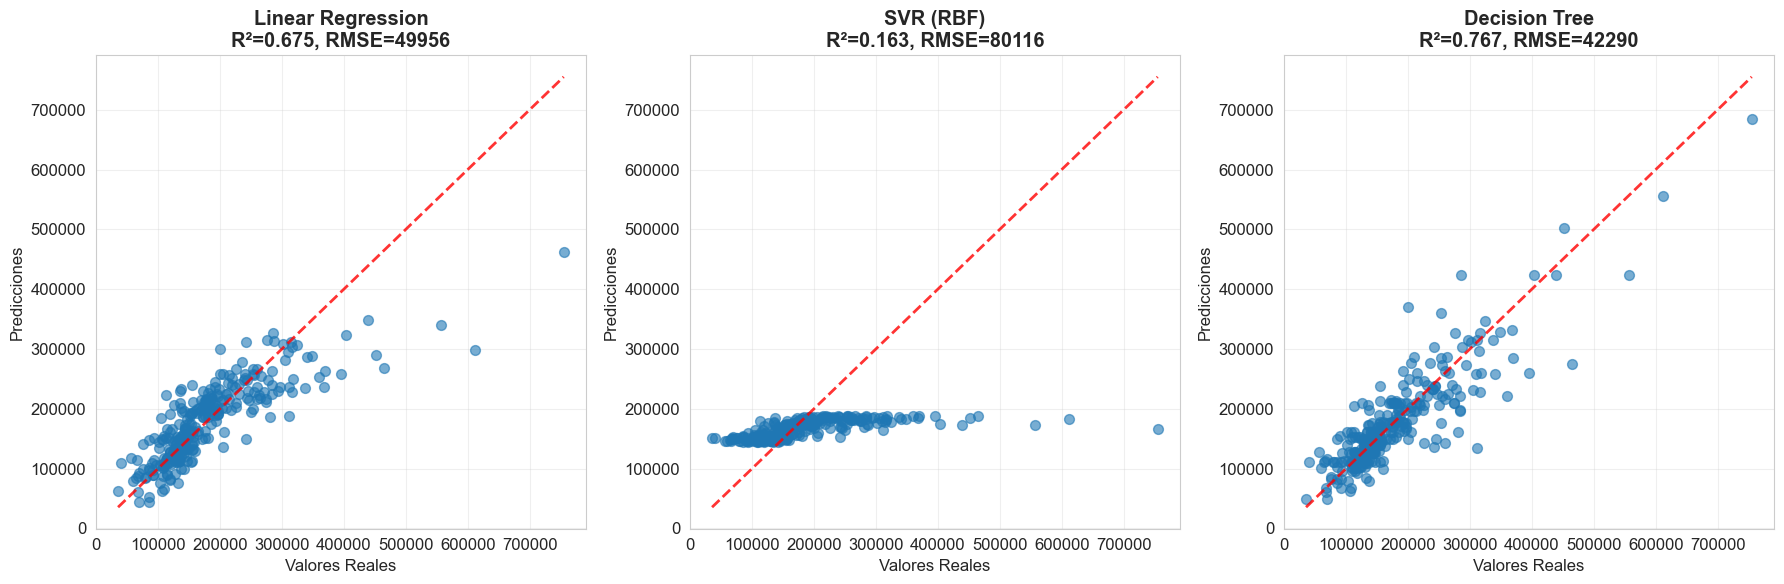

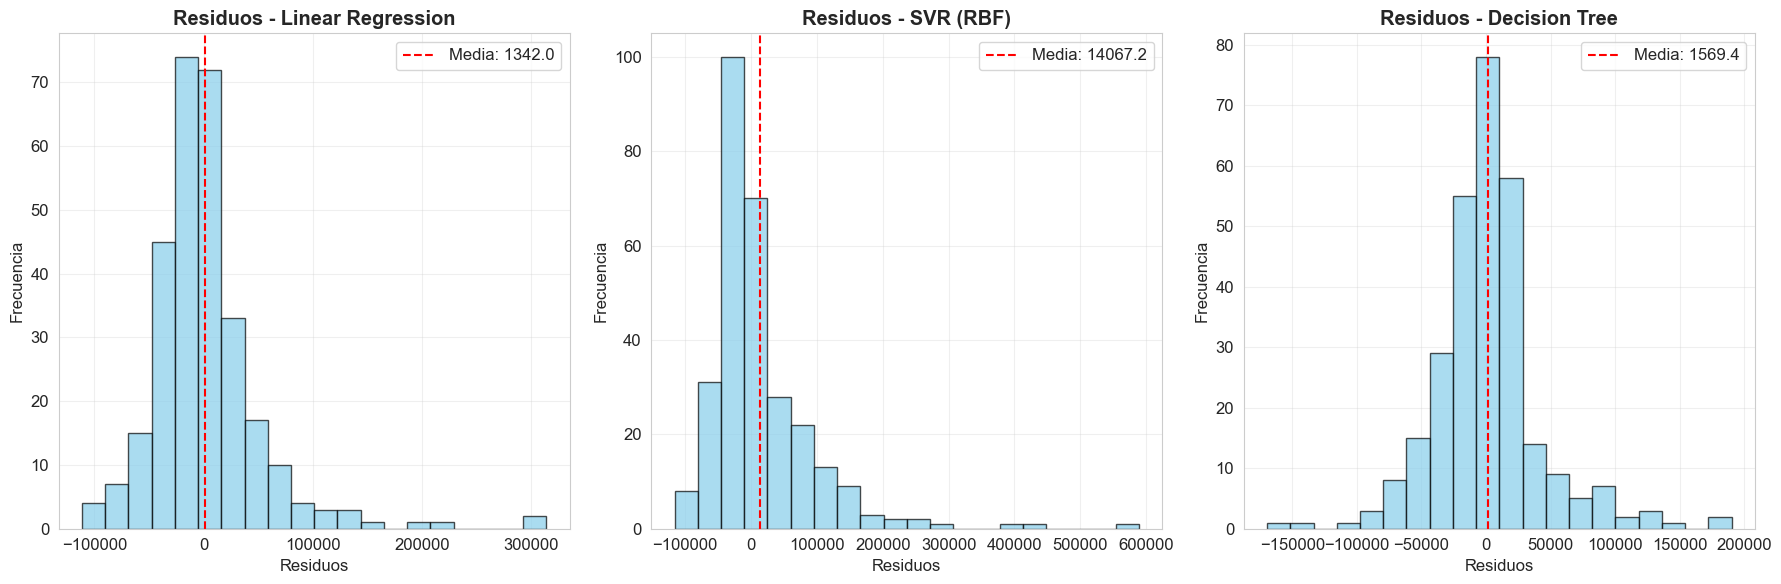


🏆 MEJOR MODELO INDIVIDUAL:
   • Modelo: Decision Tree
   • R² Test: 0.7668
✅ Modelos base entrenados y evaluados


In [6]:
# ============================================================================
# 4. MODELOS BASE INDIVIDUALES
# ============================================================================

print("\n🤖 4. ENTRENAMIENTO DE MODELOS BASE")
print("="*40)

print("🏗️ ENTRENANDO MODELOS INDIVIDUALES:")

# Inicializar modelos
models_config = {
    'Linear Regression': {
        'model': LinearRegression(),
        'data_type': 'original',
        'description': 'Regresión lineal simple'
    },
    'SVR (RBF)': {
        'model': SVR(kernel='rbf', C=100, gamma='scale'),
        'data_type': 'scaled',
        'description': 'Support Vector Regression con kernel RBF'
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42),
        'data_type': 'original',
        'description': 'Árbol de decisión con profundidad limitada'
    }
}

# Entrenar y evaluar cada modelo
individual_results = []
trained_models = {}

for model_name, config in models_config.items():
    print(f"\n🔧 Entrenando {model_name}:")
    print(f"   • {config['description']}")
    
    # Seleccionar datos apropiados
    if config['data_type'] == 'scaled':
        X_tr, X_te = X_train_scaled, X_test_scaled
    elif config['data_type'] == 'normalized':
        X_tr, X_te = X_train_normalized, X_test_normalized
    else:
        X_tr, X_te = X_train.values, X_test.values
    
    # Entrenar modelo
    model = config['model']
    model.fit(X_tr, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    
    # Evaluación
    train_results = evaluate_model(y_train, y_pred_train, f"{model_name} (Train)")
    test_results = evaluate_model(y_test, y_pred_test, f"{model_name} (Test)")
    
    individual_results.extend([train_results, test_results])
    
    # Guardar modelo entrenado
    trained_models[model_name] = {
        'model': model,
        'data_type': config['data_type'],
        'train_predictions': y_pred_train,
        'test_predictions': y_pred_test
    }
    
    print(f"   • RMSE Train: {train_results['RMSE']:.2f}")
    print(f"   • RMSE Test: {test_results['RMSE']:.2f}")
    print(f"   • R² Test: {test_results['R²']:.4f}")

# Crear DataFrame de resultados
results_df = pd.DataFrame(individual_results)
print(f"\n📊 RESUMEN DE MODELOS INDIVIDUALES:")
print(results_df.round(2))

# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, model_info) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    y_pred = model_info['test_predictions']
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.6, s=50)
    
    # Línea ideal
    min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    
    # Métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    ax.set_xlabel('Valores Reales')
    ax.set_ylabel('Predicciones')
    ax.set_title(f'{model_name}\nR²={r2:.3f}, RMSE={rmse:.0f}', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de residuos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, model_info) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    y_pred = model_info['test_predictions']
    residuals = y_test - y_pred
    
    # Histogram de residuos
    ax.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(residuals.mean(), color='red', linestyle='--', 
               label=f'Media: {residuals.mean():.1f}')
    ax.set_xlabel('Residuos')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Residuos - {model_name}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar mejor modelo individual para comparación posterior
best_individual_idx = results_df[results_df['Model'].str.contains('Test')]['R²'].idxmax()
best_individual_model = results_df.loc[best_individual_idx, 'Model'].replace(' (Test)', '')
best_individual_r2 = results_df.loc[best_individual_idx, 'R²']

print(f"\n🏆 MEJOR MODELO INDIVIDUAL:")
print(f"   • Modelo: {best_individual_model}")
print(f"   • R² Test: {best_individual_r2:.4f}")

print("✅ Modelos base entrenados y evaluados")


In [7]:
# ============================================================================
# 5. IMPLEMENTACIÓN DE BLENDING DESDE CERO
# ============================================================================

print("\n🎨 5. IMPLEMENTACIÓN DE BLENDING")
print("="*35)

print("🔗 BLENDING - COMBINACIÓN PONDERADA:")

class ScratchBlending:
    """
    Implementación desde cero de Blending (mezcla ponderada)
    
    El blending combina predicciones de múltiples modelos usando
    pesos predefinidos o optimizados.
    """
    
    def __init__(self, models, weights=None, optimize_weights=True):
        """
        Parameters
        ----------
        models : dict
            Diccionario de modelos entrenados
        weights : array-like, optional
            Pesos para cada modelo. Si None, se usan pesos iguales
        optimize_weights : bool
            Si True, optimiza pesos usando validación cruzada
        """
        self.models = models
        self.model_names = list(models.keys())
        self.n_models = len(models)
        
        if weights is None:
            # Pesos iguales por defecto
            self.weights = np.ones(self.n_models) / self.n_models
        else:
            self.weights = np.array(weights)
            
        self.optimize_weights = optimize_weights
        
        # Normalizar pesos
        self.weights = self.weights / self.weights.sum()
        
    def _get_predictions(self, X, model_name):
        """Obtiene predicciones de un modelo específico"""
        model_info = self.models[model_name]
        model = model_info['model']
        data_type = model_info['data_type']
        
        # Usar datos apropiados según el tipo de modelo
        if data_type == 'scaled':
            if hasattr(X, 'values'):
                X_transformed = scaler_standard.transform(X.values)
            else:
                X_transformed = scaler_standard.transform(X.reshape(-1, X.shape[-1]) if X.ndim == 1 else X)
        elif data_type == 'normalized':
            if hasattr(X, 'values'):
                X_transformed = scaler_minmax.transform(X.values)
            else:
                X_transformed = scaler_minmax.transform(X.reshape(-1, X.shape[-1]) if X.ndim == 1 else X)
        else:
            X_transformed = X.values if hasattr(X, 'values') else X
            
        return model.predict(X_transformed)
    
    def _optimize_weights_cv(self, X, y, cv_folds=5):
        """
        Optimiza pesos usando validación cruzada
        """
        from scipy.optimize import minimize
        
        print("   🔍 Optimizando pesos con validación cruzada...")
        
        def objective(weights):
            """Función objetivo: minimizar RMSE promedio en CV"""
            weights = weights / weights.sum()  # Normalizar
            
            cv_scores = []
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
            
            for train_idx, val_idx in kf.split(X):
                X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
                y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Entrenar modelos temporales en fold
                temp_models = {}
                for model_name, model_config in models_config.items():
                    temp_model = model_config['model'].__class__(**model_config['model'].get_params())
                    
                    # Preparar datos
                    if model_config['data_type'] == 'scaled':
                        X_tr = scaler_standard.fit_transform(X_fold_train)
                        X_val = scaler_standard.transform(X_fold_val)
                    elif model_config['data_type'] == 'normalized':
                        X_tr = scaler_minmax.fit_transform(X_fold_train)
                        X_val = scaler_minmax.transform(X_fold_val)
                    else:
                        X_tr, X_val = X_fold_train.values, X_fold_val.values
                    
                    temp_model.fit(X_tr, y_fold_train)
                    pred = temp_model.predict(X_val)
                    
                    temp_models[model_name] = pred
                
                # Combinar predicciones con pesos actuales
                blended_pred = np.zeros(len(y_fold_val))
                for i, model_name in enumerate(self.model_names):
                    blended_pred += weights[i] * temp_models[model_name]
                
                # Calcular RMSE
                rmse = np.sqrt(mean_squared_error(y_fold_val, blended_pred))
                cv_scores.append(rmse)
            
            return np.mean(cv_scores)
        
        # Optimizar pesos
        constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
        bounds = [(0, 1) for _ in range(self.n_models)]
        
        result = minimize(objective, self.weights, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            self.weights = result.x / result.x.sum()
            print(f"   ✅ Optimización exitosa. RMSE CV: {result.fun:.2f}")
        else:
            print(f"   ⚠️ Optimización falló. Usando pesos iguales.")
            
        return result.success
    
    def fit(self, X, y):
        """
        Ajustar pesos del blending
        """
        print(f"   🎯 Configurando blending con {self.n_models} modelos")
        
        if self.optimize_weights:
            self._optimize_weights_cv(X, y)
        
        print(f"   📊 Pesos finales:")
        for name, weight in zip(self.model_names, self.weights):
            print(f"     • {name}: {weight:.4f}")
            
        return self
    
    def predict(self, X):
        """
        Realizar predicción combinada
        """
        # Obtener predicciones de todos los modelos
        predictions = []
        
        for model_name in self.model_names:
            pred = self._get_predictions(X, model_name)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Combinar con pesos
        blended_prediction = np.dot(self.weights, predictions)
        
        return blended_prediction

# Aplicar Blending
print(f"\n🔗 APLICANDO BLENDING:")

# Crear instancia de blending
blending_model = ScratchBlending(
    models=trained_models,
    weights=None,  # Optimizar automáticamente
    optimize_weights=True
)

# Entrenar (optimizar pesos)
blending_model.fit(X_train, y_train)

# Predicciones
y_pred_blending_train = blending_model.predict(X_train)
y_pred_blending_test = blending_model.predict(X_test)

# Evaluación
blending_train_results = evaluate_model(y_train, y_pred_blending_train, "Blending (Train)")
blending_test_results = evaluate_model(y_test, y_pred_blending_test, "Blending (Test)")

print(f"\n📊 RESULTADOS BLENDING:")
print(f"   • RMSE Train: {blending_train_results['RMSE']:.2f}")
print(f"   • RMSE Test: {blending_test_results['RMSE']:.2f}")
print(f"   • R² Test: {blending_test_results['R²']:.4f}")
print(f"   • Mejora sobre mejor individual: {blending_test_results['R²'] - best_individual_r2:.4f}")

print("✅ Blending implementado y evaluado")



🎨 5. IMPLEMENTACIÓN DE BLENDING
🔗 BLENDING - COMBINACIÓN PONDERADA:

🔗 APLICANDO BLENDING:
   🎯 Configurando blending con 3 modelos
   🔍 Optimizando pesos con validación cruzada...
   ✅ Optimización exitosa. RMSE CV: 44770.25
   📊 Pesos finales:
     • Linear Regression: 0.7228
     • SVR (RBF): 0.0034
     • Decision Tree: 0.2738

📊 RESULTADOS BLENDING:
   • RMSE Train: 36773.80
   • RMSE Test: 45061.14
   • R² Test: 0.7353
   • Mejora sobre mejor individual: -0.0316
✅ Blending implementado y evaluado


In [8]:
# ============================================================================
# 6. IMPLEMENTACIÓN DE BAGGING DESDE CERO
# ============================================================================

print("\n📦 6. IMPLEMENTACIÓN DE BAGGING")
print("="*35)

print("🎲 BAGGING - BOOTSTRAP AGGREGATING:")

class ScratchBagging:
    """
    Implementación desde cero de Bagging
    
    Bagging entrena múltiples modelos en diferentes muestras bootstrap
    de los datos de entrenamiento y promedia sus predicciones.
    """
    
    def __init__(self, base_model, n_models=10, sample_ratio=1.0, random_state=42):
        """
        Parameters
        ----------
        base_model : sklearn estimator
            Modelo base a usar para cada estimador del ensemble
        n_models : int
            Número de modelos en el ensemble
        sample_ratio : float
            Proporción de muestras a usar en cada bootstrap
        random_state : int
            Semilla para reproducibilidad
        """
        self.base_model = base_model
        self.n_models = n_models
        self.sample_ratio = sample_ratio
        self.random_state = random_state
        self.models = []
        self.bootstrap_indices = []
        
        np.random.seed(random_state)
    
    def _create_bootstrap_sample(self, X, y):
        """
        Crear muestra bootstrap de los datos
        """
        n_samples = int(len(X) * self.sample_ratio)
        
        # Muestreo con reemplazo
        bootstrap_idx = np.random.choice(len(X), size=n_samples, replace=True)
        
        if hasattr(X, 'iloc'):
            X_bootstrap = X.iloc[bootstrap_idx]
            y_bootstrap = y.iloc[bootstrap_idx]
        else:
            X_bootstrap = X[bootstrap_idx]
            y_bootstrap = y[bootstrap_idx]
        
        return X_bootstrap, y_bootstrap, bootstrap_idx
    
    def fit(self, X, y, data_type='original'):
        """
        Entrenar ensemble de modelos con bootstrap
        """
        print(f"   🎯 Entrenando {self.n_models} modelos con bagging...")
        print(f"   • Modelo base: {self.base_model.__class__.__name__}")
        print(f"   • Ratio de muestra: {self.sample_ratio}")
        
        self.models = []
        self.bootstrap_indices = []
        
        # Preparar datos según tipo
        if data_type == 'scaled':
            X_processed = pd.DataFrame(scaler_standard.transform(X), 
                                     index=X.index, columns=X.columns)
        elif data_type == 'normalized':
            X_processed = pd.DataFrame(scaler_minmax.transform(X), 
                                     index=X.index, columns=X.columns)
        else:
            X_processed = X.copy()
        
        for i in range(self.n_models):
            # Crear muestra bootstrap
            X_boot, y_boot, boot_idx = self._create_bootstrap_sample(X_processed, y)
            
            # Crear y entrenar modelo
            model = self.base_model.__class__(**self.base_model.get_params())
            model.fit(X_boot, y_boot)
            
            self.models.append(model)
            self.bootstrap_indices.append(boot_idx)
            
            if (i + 1) % 5 == 0:
                print(f"     • Modelos entrenados: {i + 1}/{self.n_models}")
        
        print(f"   ✅ Bagging completado")
        return self
    
    def predict(self, X, data_type='original'):
        """
        Realizar predicción promediando todos los modelos
        """
        # Preparar datos según tipo
        if data_type == 'scaled':
            if hasattr(X, 'values'):
                X_processed = scaler_standard.transform(X.values)
            else:
                X_processed = scaler_standard.transform(X)
        elif data_type == 'normalized':
            if hasattr(X, 'values'):
                X_processed = scaler_minmax.transform(X.values)
            else:
                X_processed = scaler_minmax.transform(X)
        else:
            X_processed = X.values if hasattr(X, 'values') else X
        
        # Recopilar predicciones de todos los modelos
        predictions = np.zeros((len(X), self.n_models))
        
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X_processed)
        
        # Promedio de predicciones
        return np.mean(predictions, axis=1)
    
    def get_model_stats(self):
        """
        Obtener estadísticas sobre la diversidad de los modelos
        """
        stats = {
            'n_models': len(self.models),
            'sample_sizes': [len(idx) for idx in self.bootstrap_indices],
            'unique_samples': [len(np.unique(idx)) for idx in self.bootstrap_indices]
        }
        return stats

# Aplicar Bagging con diferentes modelos base
print(f"\n📦 APLICANDO BAGGING:")

# Configuraciones de bagging
bagging_configs = {
    'Bagging + DecisionTree': {
        'base_model': DecisionTreeRegressor(max_depth=15, min_samples_split=5, random_state=42),
        'data_type': 'original',
        'n_models': 15
    },
    'Bagging + LinearRegression': {
        'base_model': LinearRegression(),
        'data_type': 'original',
        'n_models': 10
    }
}

bagging_results = []
bagging_models = {}

for config_name, config in bagging_configs.items():
    print(f"\n🔧 {config_name}:")
    
    # Crear y entrenar modelo de bagging
    bagging_model = ScratchBagging(
        base_model=config['base_model'],
        n_models=config['n_models'],
        sample_ratio=0.8,  # 80% de datos en cada bootstrap
        random_state=42
    )
    
    bagging_model.fit(X_train, y_train, data_type=config['data_type'])
    
    # Predicciones
    y_pred_bag_train = bagging_model.predict(X_train, data_type=config['data_type'])
    y_pred_bag_test = bagging_model.predict(X_test, data_type=config['data_type'])
    
    # Evaluación
    train_results = evaluate_model(y_train, y_pred_bag_train, f"{config_name} (Train)")
    test_results = evaluate_model(y_test, y_pred_bag_test, f"{config_name} (Test)")
    
    bagging_results.extend([train_results, test_results])
    bagging_models[config_name] = {
        'model': bagging_model,
        'train_predictions': y_pred_bag_train,
        'test_predictions': y_pred_bag_test,
        'config': config
    }
    
    # Estadísticas del modelo
    stats = bagging_model.get_model_stats()
    print(f"   • Modelos en ensemble: {stats['n_models']}")
    print(f"   • Tamaño promedio muestra: {np.mean(stats['sample_sizes']):.0f}")
    print(f"   • Muestras únicas promedio: {np.mean(stats['unique_samples']):.0f}")
    print(f"   • RMSE Test: {test_results['RMSE']:.2f}")
    print(f"   • R² Test: {test_results['R²']:.4f}")

# Comparar con Random Forest de sklearn
print(f"\n🌲 COMPARACIÓN CON RANDOM FOREST (sklearn):")
rf_model = RandomForestRegressor(n_estimators=15, max_depth=15, 
                                min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf_test = rf_model.predict(X_test)
rf_results = evaluate_model(y_test, y_pred_rf_test, "Random Forest (Test)")
bagging_results.append(rf_results)

print(f"   • RMSE Test: {rf_results['RMSE']:.2f}")
print(f"   • R² Test: {rf_results['R²']:.4f}")

# Crear DataFrame de resultados de bagging
bagging_results_df = pd.DataFrame(bagging_results)
print(f"\n📊 RESUMEN DE BAGGING:")
print(bagging_results_df.round(3))

print("✅ Bagging implementado y evaluado")



📦 6. IMPLEMENTACIÓN DE BAGGING
🎲 BAGGING - BOOTSTRAP AGGREGATING:

📦 APLICANDO BAGGING:

🔧 Bagging + DecisionTree:
   🎯 Entrenando 15 modelos con bagging...
   • Modelo base: DecisionTreeRegressor
   • Ratio de muestra: 0.8
     • Modelos entrenados: 5/15
     • Modelos entrenados: 10/15
     • Modelos entrenados: 15/15
   ✅ Bagging completado
   • Modelos en ensemble: 15
   • Tamaño promedio muestra: 934
   • Muestras únicas promedio: 641
   • RMSE Test: 42058.83
   • R² Test: 0.7694

🔧 Bagging + LinearRegression:
   🎯 Entrenando 10 modelos con bagging...
   • Modelo base: LinearRegression
   • Ratio de muestra: 0.8
     • Modelos entrenados: 5/10
     • Modelos entrenados: 10/10
   ✅ Bagging completado
   • Modelos en ensemble: 10
   • Tamaño promedio muestra: 934
   • Muestras únicas promedio: 640
   • RMSE Test: 49822.60
   • R² Test: 0.6764

🌲 COMPARACIÓN CON RANDOM FOREST (sklearn):
   • RMSE Test: 39729.96
   • R² Test: 0.7942

📊 RESUMEN DE BAGGING:
                            

In [9]:
# ============================================================================
# 7. IMPLEMENTACIÓN DE STACKING DESDE CERO
# ============================================================================

print("\n🏗️ 7. IMPLEMENTACIÓN DE STACKING")
print("="*35)

print("🎯 STACKING - APRENDIZAJE EN MÚLTIPLES NIVELES:")

class ScratchStacking:
    """
    Implementación desde cero de Stacking
    
    Stacking entrena múltiples modelos de primer nivel y luego
    usa un meta-modelo para combinar sus predicciones.
    """
    
    def __init__(self, level0_models, meta_model, cv_folds=5, random_state=42):
        """
        Parameters
        ----------
        level0_models : dict
            Diccionario de modelos de primer nivel
        meta_model : sklearn estimator
            Modelo meta para combinar predicciones
        cv_folds : int
            Número de folds para validación cruzada
        random_state : int
            Semilla para reproducibilidad
        """
        self.level0_models = level0_models
        self.meta_model = meta_model
        self.cv_folds = cv_folds
        self.random_state = random_state
        
        # Modelos entrenados
        self.trained_level0_models = {}
        self.trained_meta_model = None
        
        np.random.seed(random_state)
    
    def _get_oof_predictions(self, X, y):
        """
        Generar predicciones out-of-fold para entrenamiento del meta-modelo
        """
        print(f"   🔄 Generando predicciones out-of-fold...")
        
        n_samples = len(X)
        n_models = len(self.level0_models)
        
        # Matriz para almacenar predicciones OOF
        oof_predictions = np.zeros((n_samples, n_models))
        
        # Configurar validación cruzada
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        
        for model_idx, (model_name, model_config) in enumerate(self.level0_models.items()):
            print(f"     • Procesando {model_name}...")
            
            # Predicciones para este modelo
            model_oof_pred = np.zeros(n_samples)
            
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                # Dividir datos
                X_fold_train = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
                X_fold_val = X.iloc[val_idx] if hasattr(X, 'iloc') else X[val_idx]
                y_fold_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
                
                # Preparar datos según tipo
                data_type = model_config['data_type']
                if data_type == 'scaled':
                    temp_scaler = StandardScaler()
                    X_fold_train_proc = temp_scaler.fit_transform(X_fold_train)
                    X_fold_val_proc = temp_scaler.transform(X_fold_val)
                elif data_type == 'normalized':
                    temp_scaler = MinMaxScaler()
                    X_fold_train_proc = temp_scaler.fit_transform(X_fold_train)
                    X_fold_val_proc = temp_scaler.transform(X_fold_val)
                else:
                    X_fold_train_proc = X_fold_train.values if hasattr(X_fold_train, 'values') else X_fold_train
                    X_fold_val_proc = X_fold_val.values if hasattr(X_fold_val, 'values') else X_fold_val
                
                # Entrenar modelo temporal
                temp_model = model_config['model'].__class__(**model_config['model'].get_params())
                temp_model.fit(X_fold_train_proc, y_fold_train)
                
                # Predecir en validation fold
                fold_predictions = temp_model.predict(X_fold_val_proc)
                model_oof_pred[val_idx] = fold_predictions
            
            # Guardar predicciones OOF para este modelo
            oof_predictions[:, model_idx] = model_oof_pred
        
        print(f"   ✅ Predicciones OOF generadas: {oof_predictions.shape}")
        return oof_predictions
    
    def fit(self, X, y):
        """
        Entrenar stacking: modelos de nivel 0 y meta-modelo
        """
        print(f"   🎯 Entrenando stacking con {len(self.level0_models)} modelos base")
        
        # Paso 1: Generar predicciones out-of-fold
        oof_predictions = self._get_oof_predictions(X, y)
        
        # Paso 2: Entrenar modelos de nivel 0 en datos completos
        print(f"   🏗️ Entrenando modelos de nivel 0 en datos completos...")
        
        for model_name, model_config in self.level0_models.items():
            # Preparar datos
            data_type = model_config['data_type']
            if data_type == 'scaled':
                X_processed = scaler_standard.fit_transform(X) if not hasattr(self, '_scaler_fitted') else scaler_standard.transform(X)
            elif data_type == 'normalized':
                X_processed = scaler_minmax.fit_transform(X) if not hasattr(self, '_minmax_fitted') else scaler_minmax.transform(X)
            else:
                X_processed = X.values if hasattr(X, 'values') else X
            
            # Entrenar modelo
            model = model_config['model'].__class__(**model_config['model'].get_params())
            model.fit(X_processed, y)
            
            # Guardar modelo entrenado
            self.trained_level0_models[model_name] = {
                'model': model,
                'data_type': data_type
            }
        
        # Marcar escaladores como ajustados
        self._scaler_fitted = True
        self._minmax_fitted = True
        
        # Paso 3: Entrenar meta-modelo usando predicciones OOF
        print(f"   🧠 Entrenando meta-modelo...")
        self.trained_meta_model = self.meta_model.__class__(**self.meta_model.get_params())
        self.trained_meta_model.fit(oof_predictions, y)
        
        print(f"   ✅ Stacking entrenado exitosamente")
        return self
    
    def predict(self, X):
        """
        Realizar predicción usando stacking
        """
        if not self.trained_level0_models or self.trained_meta_model is None:
            raise ValueError("El modelo debe ser entrenado antes de predecir")
        
        # Paso 1: Obtener predicciones de modelos nivel 0
        level0_predictions = np.zeros((len(X), len(self.trained_level0_models)))
        
        for model_idx, (model_name, model_info) in enumerate(self.trained_level0_models.items()):
            model = model_info['model']
            data_type = model_info['data_type']
            
            # Preparar datos
            if data_type == 'scaled':
                X_processed = scaler_standard.transform(X) if hasattr(X, 'values') else scaler_standard.transform(X.reshape(-1, X.shape[-1]))
            elif data_type == 'normalized':
                X_processed = scaler_minmax.transform(X) if hasattr(X, 'values') else scaler_minmax.transform(X.reshape(-1, X.shape[-1]))
            else:
                X_processed = X.values if hasattr(X, 'values') else X
            
            # Obtener predicciones
            level0_predictions[:, model_idx] = model.predict(X_processed)
        
        # Paso 2: Meta-modelo hace predicción final
        final_predictions = self.trained_meta_model.predict(level0_predictions)
        
        return final_predictions
    
    def get_level0_predictions(self, X):
        """
        Obtener predicciones de los modelos de nivel 0 (para análisis)
        """
        level0_predictions = np.zeros((len(X), len(self.trained_level0_models)))
        
        for model_idx, (model_name, model_info) in enumerate(self.trained_level0_models.items()):
            model = model_info['model']
            data_type = model_info['data_type']
            
            if data_type == 'scaled':
                X_processed = scaler_standard.transform(X) if hasattr(X, 'values') else scaler_standard.transform(X)
            elif data_type == 'normalized':
                X_processed = scaler_minmax.transform(X) if hasattr(X, 'values') else scaler_minmax.transform(X)
            else:
                X_processed = X.values if hasattr(X, 'values') else X
            
            level0_predictions[:, model_idx] = model.predict(X_processed)
        
        return level0_predictions, list(self.trained_level0_models.keys())

# Aplicar Stacking
print(f"\n🏗️ APLICANDO STACKING:")

# Configurar modelos para stacking (usando configuración de modelos individuales)
stacking_level0_models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'data_type': 'original'
    },
    'SVR': {
        'model': SVR(kernel='rbf', C=100, gamma='scale'),
        'data_type': 'scaled'
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42),
        'data_type': 'original'
    }
}

# Meta-modelo (modelo simple para combinar)
meta_model = LinearRegression()

# Crear y entrenar modelo de stacking
stacking_model = ScratchStacking(
    level0_models=stacking_level0_models,
    meta_model=meta_model,
    cv_folds=5,
    random_state=42
)

stacking_model.fit(X_train, y_train)

# Predicciones
y_pred_stacking_train = stacking_model.predict(X_train)
y_pred_stacking_test = stacking_model.predict(X_test)

# Evaluación
stacking_train_results = evaluate_model(y_train, y_pred_stacking_train, "Stacking (Train)")
stacking_test_results = evaluate_model(y_test, y_pred_stacking_test, "Stacking (Test)")

print(f"\n📊 RESULTADOS STACKING:")
print(f"   • RMSE Train: {stacking_train_results['RMSE']:.2f}")
print(f"   • RMSE Test: {stacking_test_results['RMSE']:.2f}")
print(f"   • R² Test: {stacking_test_results['R²']:.4f}")
print(f"   • Mejora sobre mejor individual: {stacking_test_results['R²'] - best_individual_r2:.4f}")

# Análisis de predicciones de nivel 0
level0_preds, level0_names = stacking_model.get_level0_predictions(X_test)

print(f"\n🔍 ANÁLISIS DE PREDICCIONES NIVEL 0:")
level0_df = pd.DataFrame(level0_preds, columns=level0_names)
level0_df['Meta_Prediction'] = y_pred_stacking_test
level0_df['Actual'] = y_test.values

print("Correlaciones entre modelos nivel 0:")
corr_matrix = level0_df.corr()
print(corr_matrix.round(3))

print("✅ Stacking implementado y evaluado")



🏗️ 7. IMPLEMENTACIÓN DE STACKING
🎯 STACKING - APRENDIZAJE EN MÚLTIPLES NIVELES:

🏗️ APLICANDO STACKING:
   🎯 Entrenando stacking con 3 modelos base
   🔄 Generando predicciones out-of-fold...
     • Procesando Linear Regression...
     • Procesando SVR...
     • Procesando Decision Tree...
   ✅ Predicciones OOF generadas: (1168, 3)
   🏗️ Entrenando modelos de nivel 0 en datos completos...
   🧠 Entrenando meta-modelo...
   ✅ Stacking entrenado exitosamente

📊 RESULTADOS STACKING:
   • RMSE Train: 37330.18
   • RMSE Test: 45510.39
   • R² Test: 0.7300
   • Mejora sobre mejor individual: -0.0369

🔍 ANÁLISIS DE PREDICCIONES NIVEL 0:
Correlaciones entre modelos nivel 0:
                   Linear Regression    SVR  Decision Tree  Meta_Prediction  \
Linear Regression              1.000  0.850          0.886            0.990   
SVR                            0.850  1.000          0.684            0.828   
Decision Tree                  0.886  0.684          1.000            0.942   
Meta_Predi


🏆 8. COMPARACIÓN FINAL DE MÉTODOS
📊 TABLA COMPARATIVA COMPLETA:
       Method                       Model        RMSE         MAE      R²  \
0  Individual           Linear Regression  49955.5292  32358.7713  0.6746   
1  Individual                   SVR (RBF)  80115.9845  48608.6569  0.1632   
2  Individual               Decision Tree  42290.2968  28793.0753  0.7668   
3    Blending            Weighted Average  45061.1381  29985.2847  0.7353   
4     Bagging      Bagging + DecisionTree  42058.8315  27988.7374  0.7694   
5     Bagging  Bagging + LinearRegression  49822.5963  32401.5226  0.6764   
6     Bagging               Random Forest  39729.9555  28057.6034  0.7942   
7    Stacking               Meta-Learning  45510.3862  30122.8897  0.7300   

         Type  
0  Base Model  
1  Base Model  
2  Base Model  
3    Ensemble  
4    Ensemble  
5    Ensemble  
6    Ensemble  
7    Ensemble  

🥇 MEJORES MODELOS POR CATEGORÍA:
   🏅 Mejor Individual: Decision Tree (R²: 0.7668)
   🏅 Mejor En

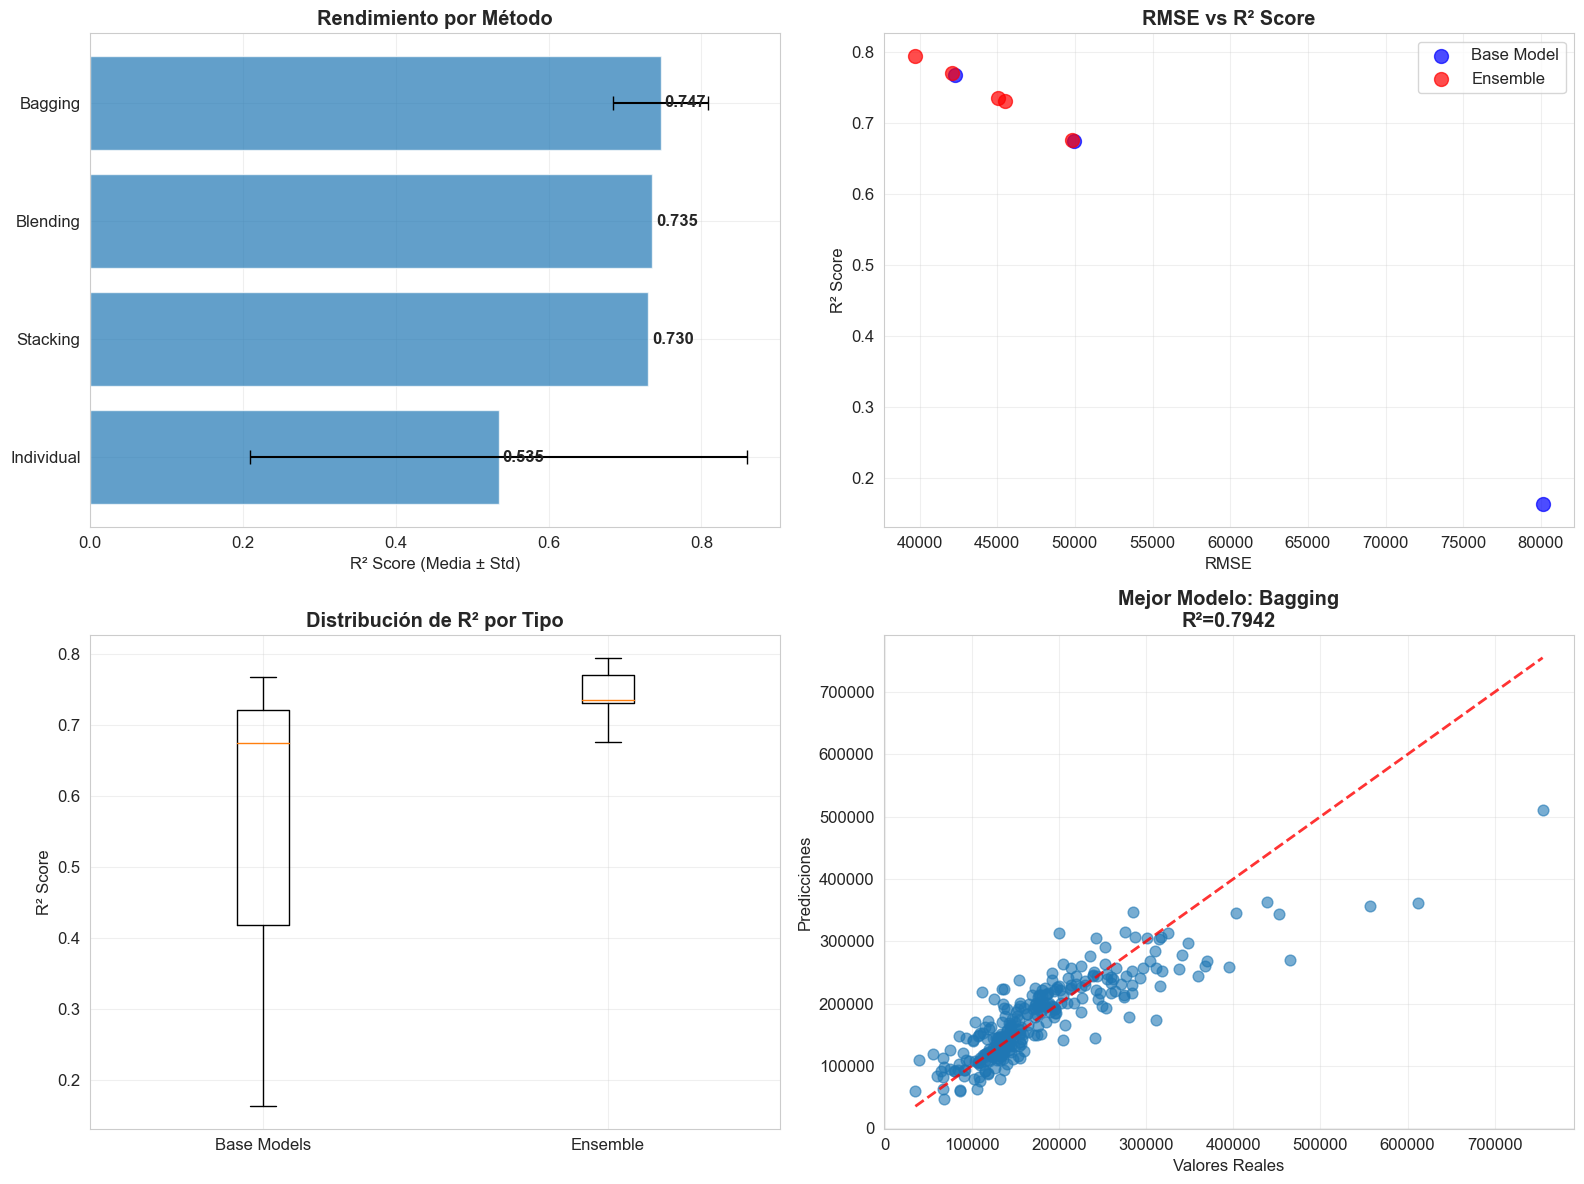


📊 ESTADÍSTICAS FINALES:
   • Modelos evaluados: 8
   • Rango R²: 0.1632 - 0.7942
   • R² promedio individuales: 0.5349
   • R² promedio ensembles: 0.7410
   • Diferencia promedio: 0.2062
✅ Comparación final completada


In [10]:
# ============================================================================
# 8. COMPARACIÓN FINAL DE TODOS LOS MÉTODOS
# ============================================================================

print("\n🏆 8. COMPARACIÓN FINAL DE MÉTODOS")
print("="*40)

# Recopilar todos los resultados
all_results = []

# Modelos individuales (solo test)
individual_test_results = results_df[results_df['Model'].str.contains('Test')].copy()
for _, row in individual_test_results.iterrows():
    all_results.append({
        'Method': 'Individual',
        'Model': row['Model'].replace(' (Test)', ''),
        'RMSE': row['RMSE'],
        'MAE': row['MAE'],
        'R²': row['R²'],
        'Type': 'Base Model'
    })

# Blending
all_results.append({
    'Method': 'Blending',
    'Model': 'Weighted Average',
    'RMSE': blending_test_results['RMSE'],
    'MAE': blending_test_results['MAE'],
    'R²': blending_test_results['R²'],
    'Type': 'Ensemble'
})

# Bagging (solo test results)
bagging_test_only = bagging_results_df[bagging_results_df['Model'].str.contains('Test')].copy()
for _, row in bagging_test_only.iterrows():
    all_results.append({
        'Method': 'Bagging',
        'Model': row['Model'].replace(' (Test)', ''),
        'RMSE': row['RMSE'],
        'MAE': row['MAE'],
        'R²': row['R²'],
        'Type': 'Ensemble'
    })

# Stacking
all_results.append({
    'Method': 'Stacking',
    'Model': 'Meta-Learning',
    'RMSE': stacking_test_results['RMSE'],
    'MAE': stacking_test_results['MAE'],
    'R²': stacking_test_results['R²'],
    'Type': 'Ensemble'
})

# Crear DataFrame final
final_results_df = pd.DataFrame(all_results)

print("📊 TABLA COMPARATIVA COMPLETA:")
print("="*50)
print(final_results_df.round(4))

# Encontrar mejores modelos por categoría
print(f"\n🥇 MEJORES MODELOS POR CATEGORÍA:")

best_individual = final_results_df[final_results_df['Type'] == 'Base Model'].loc[
    final_results_df[final_results_df['Type'] == 'Base Model']['R²'].idxmax()
]

best_ensemble = final_results_df[final_results_df['Type'] == 'Ensemble'].loc[
    final_results_df[final_results_df['Type'] == 'Ensemble']['R²'].idxmax()
]

best_overall = final_results_df.loc[final_results_df['R²'].idxmax()]

print(f"   🏅 Mejor Individual: {best_individual['Model']} (R²: {best_individual['R²']:.4f})")
print(f"   🏅 Mejor Ensemble: {best_ensemble['Method']} - {best_ensemble['Model']} (R²: {best_ensemble['R²']:.4f})")
print(f"   🏅 Mejor General: {best_overall['Method']} - {best_overall['Model']} (R²: {best_overall['R²']:.4f})")

# Calcular mejoras
improvement_over_best_individual = best_ensemble['R²'] - best_individual['R²']
improvement_percentage = (improvement_over_best_individual / best_individual['R²']) * 100

print(f"\n📈 ANÁLISIS DE MEJORAS:")
print(f"   • Mejora absoluta ensemble: +{improvement_over_best_individual:.4f} R²")
print(f"   • Mejora relativa: +{improvement_percentage:.1f}%")

# Visualización comparativa final
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico de barras por método
methods_grouped = final_results_df.groupby('Method')['R²'].agg(['mean', 'std', 'max'])
methods_grouped = methods_grouped.sort_values('mean', ascending=True)

bars = axes[0,0].barh(range(len(methods_grouped)), methods_grouped['mean'], 
                     xerr=methods_grouped['std'], alpha=0.7, capsize=5)
axes[0,0].set_yticks(range(len(methods_grouped)))
axes[0,0].set_yticklabels(methods_grouped.index)
axes[0,0].set_xlabel('R² Score (Media ± Std)')
axes[0,0].set_title('Rendimiento por Método', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Agregar valores en barras
for i, (bar, mean_val) in enumerate(zip(bars, methods_grouped['mean'])):
    axes[0,0].text(mean_val + 0.005, bar.get_y() + bar.get_height()/2, 
                  f'{mean_val:.3f}', ha='left', va='center', fontweight='bold')

# Scatter plot RMSE vs R²
colors = {'Base Model': 'blue', 'Ensemble': 'red'}
for model_type, color in colors.items():
    mask = final_results_df['Type'] == model_type
    axes[0,1].scatter(final_results_df[mask]['RMSE'], final_results_df[mask]['R²'], 
                     c=color, alpha=0.7, s=100, label=model_type)

axes[0,1].set_xlabel('RMSE')
axes[0,1].set_ylabel('R² Score')
axes[0,1].set_title('RMSE vs R² Score', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Boxplot de R² por tipo
base_r2 = final_results_df[final_results_df['Type'] == 'Base Model']['R²']
ensemble_r2 = final_results_df[final_results_df['Type'] == 'Ensemble']['R²']

axes[1,0].boxplot([base_r2, ensemble_r2], labels=['Base Models', 'Ensemble'])
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_title('Distribución de R² por Tipo', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Predicciones vs valores reales para mejor modelo
if best_overall['Method'] == 'Stacking':
    best_predictions = y_pred_stacking_test
elif best_overall['Method'] == 'Blending':
    best_predictions = y_pred_blending_test
else:
    # Buscar en modelos de bagging
    best_model_key = None
    for key in bagging_models:
        if best_overall['Model'] in key:
            best_model_key = key
            break
    best_predictions = bagging_models[best_model_key]['test_predictions'] if best_model_key else y_pred_stacking_test

axes[1,1].scatter(y_test, best_predictions, alpha=0.6, s=60)
min_val, max_val = min(y_test.min(), best_predictions.min()), max(y_test.max(), best_predictions.max())
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

axes[1,1].set_xlabel('Valores Reales')
axes[1,1].set_ylabel('Predicciones')
axes[1,1].set_title(f'Mejor Modelo: {best_overall["Method"]}\nR²={best_overall["R²"]:.4f}', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen estadístico
print(f"\n📊 ESTADÍSTICAS FINALES:")
print(f"   • Modelos evaluados: {len(final_results_df)}")
print(f"   • Rango R²: {final_results_df['R²'].min():.4f} - {final_results_df['R²'].max():.4f}")
print(f"   • R² promedio individuales: {final_results_df[final_results_df['Type'] == 'Base Model']['R²'].mean():.4f}")
print(f"   • R² promedio ensembles: {final_results_df[final_results_df['Type'] == 'Ensemble']['R²'].mean():.4f}")
print(f"   • Diferencia promedio: {final_results_df[final_results_df['Type'] == 'Ensemble']['R²'].mean() - final_results_df[final_results_df['Type'] == 'Base Model']['R²'].mean():.4f}")

print("✅ Comparación final completada")
